In [1]:
import torch
from models.resnet import Resnet1D
N_CH = 8

In [2]:
x = torch.randn(1, 20, 100) # (batch_size, length, channels)
resnet = Resnet1D(n_in = 20, n_depth=3, dilation_growth_rate=1)

out = resnet(x)
print(out.shape) # (1, 20, 5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using  device: {device}")

torch.Size([1, 20, 100])
using  device: cuda


In [3]:
# count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {count_parameters(resnet)}")

Number of parameters: 4920


In [4]:
from models.encdec import Encoder

encoder = Encoder(input_emb_width=20)
encoder(x).shape

torch.Size([1, 512, 12])

In [5]:
from models.vqvae import VQVAE_251
args = {
    "quantizer": "ema"
}
vqvae = VQVAE_251(
    args
)

In [6]:
x = torch.randn(1, 128, 20) # (batch_size, length, channels)
vqvae(x)[0].shape


torch.Size([1, 128, 20])

In [7]:
vqvae.encode(x).shape

torch.Size([1, 16])

In [8]:
import numpy as np

def generate_sine_wave_data(batch_size, time_steps, channels, split_ratio=0.8, noise_std=0.05, seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)

    # 周波数・位相をランダムにする（チャンネルごと）
    freqs = np.random.uniform(1.5, 2.0, size=(batch_size, channels))
    phases = np.random.uniform(0, 2*np.pi, size=(batch_size, channels))

    # 時間軸
    t = np.linspace(0, 2 * np.pi, time_steps)

    # データ生成
    data = []
    for b in range(batch_size):
        sample = []
        for c in range(channels):
            y = np.sin(freqs[b, c] * t + phases[b, c])
            y += np.random.normal(0, noise_std, size=y.shape)
            sample.append(y)
        sample = np.stack(sample, axis=-1)  # [Time, Channel]
        data.append(sample)

    data = np.stack(data, axis=0)  # [Batch, Time, Channel]
    data_tensor = torch.tensor(data, dtype=torch.float32)

    # Split into train / val
    split_idx = int(batch_size * split_ratio)
    train_data = data_tensor[:split_idx]
    val_data = data_tensor[split_idx:]

    return train_data, val_data

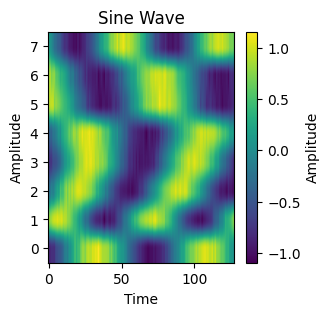

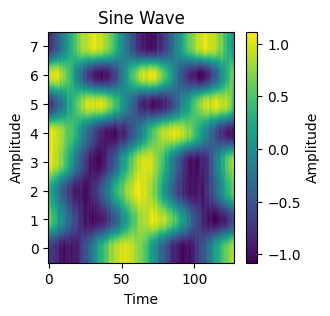

In [9]:
train, val = generate_sine_wave_data(10000, 128, N_CH, split_ratio=0.8, noise_std=0.05, seed=42)

# imshow
import matplotlib.pyplot as plt
import numpy as np
def plot_sine_wave(data, title="Sine Wave", xlabel="Time", ylabel="Amplitude"):
    # imshow
    plt.figure(figsize=(3, 3))
    plt.imshow(data, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Amplitude')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.show()

plot_sine_wave(train[0].numpy().T, title="Sine Wave", xlabel="Time", ylabel="Amplitude")
plot_sine_wave(val[0].numpy().T, title="Sine Wave", xlabel="Time", ylabel="Amplitude")


In [31]:
args = {
    "quantizer": "ema"
}
model = VQVAE_251(
    args,
    nb_code=128,
    n_channels=N_CH
)
lossi = []

# train model
from torch.utils.data import DataLoader, TensorDataset
from schedulefree import RAdamScheduleFree

train_dataset = TensorDataset(train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
optimizer = RAdamScheduleFree(model.parameters(), lr=3e-4)
num_epochs = 30

model = model.to(device)  # Move the model to the device

In [32]:

def calculate_eval_loss(model, data_loader, device):
    with torch.no_grad():
        total_loss = 0
        for batch in data_loader:
            x = batch[0].to(device)
            x_out, q_loss, perplexity = model(x)
            loss_recon = torch.mean((x - x_out) ** 2)
            loss = loss_recon + q_loss * 0.25
            total_loss += loss.item()
        avg_loss = total_loss / len(data_loader)
        return avg_loss


for epoch in range(num_epochs):
    steps = 0
    for batch in train_loader:
        optimizer.train()
        x = batch[0].to(device)  # Move the input batch to the device
        optimizer.zero_grad()
        x_out, q_loss, perplexity = model(x)

        loss_recon = torch.mean((x - x_out) ** 2)
        loss = loss_recon + q_loss * 0.25
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
        steps += 1
        if steps % 100 == 0:
            optimizer.eval()
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{steps}], Loss: {loss.item():.4f}, Recon Loss: {loss_recon.item():.4f}, Quantization Loss: {q_loss.item():.4f}, Perplexity: {perplexity.item():.4f}")
            val_loss = calculate_eval_loss(model, val_loader, device)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}")

Epoch [1/30], Step [100], Loss: 0.3842, Recon Loss: 0.3515, Quantization Loss: 0.1310, Perplexity: 13.5529
Epoch [1/30], Validation Loss: 0.3783
Epoch [1/30], Step [200], Loss: 0.2982, Recon Loss: 0.2637, Quantization Loss: 0.1381, Perplexity: 31.1642
Epoch [1/30], Validation Loss: 0.3068
Epoch [2/30], Step [100], Loss: 0.1982, Recon Loss: 0.1577, Quantization Loss: 0.1620, Perplexity: 65.8478
Epoch [2/30], Validation Loss: 0.1851
Epoch [2/30], Step [200], Loss: 0.1251, Recon Loss: 0.0829, Quantization Loss: 0.1685, Perplexity: 94.2461
Epoch [2/30], Validation Loss: 0.1160
Epoch [3/30], Step [100], Loss: 0.0802, Recon Loss: 0.0456, Quantization Loss: 0.1384, Perplexity: 99.1772
Epoch [3/30], Validation Loss: 0.0813
Epoch [3/30], Step [200], Loss: 0.0722, Recon Loss: 0.0407, Quantization Loss: 0.1262, Perplexity: 104.1885
Epoch [3/30], Validation Loss: 0.0710
Epoch [4/30], Step [100], Loss: 0.0626, Recon Loss: 0.0340, Quantization Loss: 0.1145, Perplexity: 107.6750
Epoch [4/30], Validat

KeyboardInterrupt: 

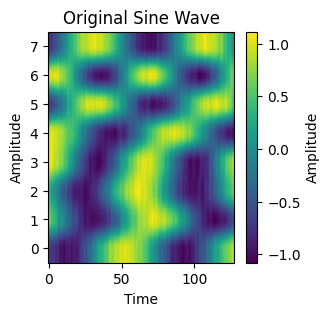

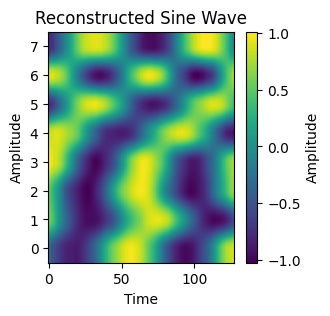

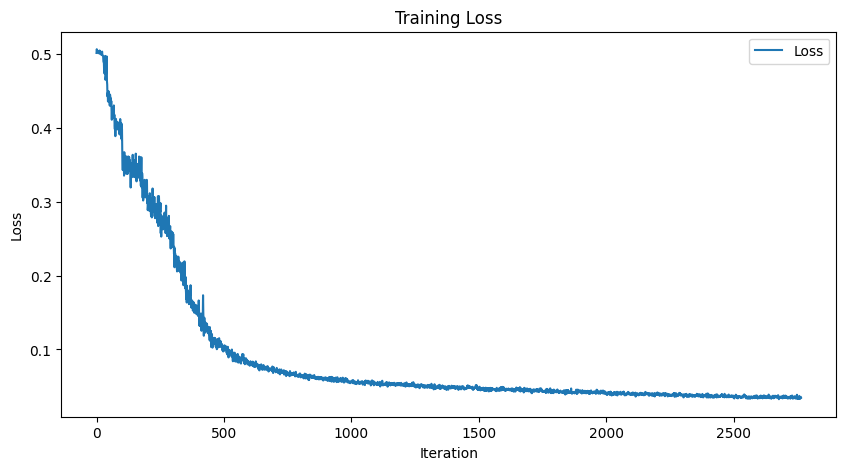

In [33]:

model.eval()
with torch.no_grad():
    recon = model(val[0:1].to(device))[0]
    plot_sine_wave(val[0].cpu().numpy().T, title="Original Sine Wave", xlabel="Time", ylabel="Amplitude")
    plot_sine_wave(recon[0].cpu().numpy().T, title="Reconstructed Sine Wave", xlabel="Time", ylabel="Amplitude")

# plot loss
plt.figure(figsize=(10, 5))
plt.plot(lossi, label='Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [34]:
data = []

with torch.no_grad():
    for d in train_loader:
        x = d[0].to(device)
        enc = model.encode(x)
        # print(enc.shape, enc) # 32, 16 = B, tokens
        # to numpy array
        enc = enc.cpu().numpy()
        # append to data
        data.append(enc)


In [35]:
dataset = np.vstack(data)  # [Batch, Time, Channel]
print(dataset.shape)  # (32, 16)

(8000, 16)


In [36]:
# save model
torch.save(model.state_dict(), "vqvae.pth")

# save dataset
np.save("dataset.npy", dataset)

In [37]:
import math, os, time, urllib.request, torch.nn as nn, torch.nn.functional as F

# ------------------ Hyper‑parameters ------------------
batch_size   = 32        # sequences per gradient step
block_size   = 8       # context length
n_epochs     = 20        # feel free to raise
lr           = 3e-4
eval_interval = 200      # mini‑batches between loss reports
n_embd       = 384
n_heads      = 3
n_layers     = 3
dropout      = 0.2
device       = "cuda" if torch.cuda.is_available() else "cpu"
vocab_size   = 128
torch.manual_seed(1337)
# ------------------------------------------------------
class CharacterTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.tok_emb = nn.Embedding(vocab_size, n_embd)
    self.pos_emb  = nn.Parameter(torch.randn(block_size, n_embd) / math.sqrt(n_embd))
    encoder_layer = nn.TransformerEncoderLayer(
        d_model = n_embd,
        nhead = n_heads,
        dim_feedforward = 4 * n_embd,
        dropout = dropout,
        activation = "gelu",
        batch_first = True
    )

    self.transformer = nn.TransformerEncoder(
        encoder_layer,
        num_layers = n_layers
    )

    self.lm_head = nn.Linear(n_embd, vocab_size) # logits

  def _causal_mask(self, L):
    mask = torch.triu(torch.ones(L, L, device=device), diagonal=1)
    mask = mask.masked_fill(mask==1, float("-inf"))
    return mask

  def forward(self, x, targets=None):
    B, T = x.shape
    tok_emb = self.tok_emb(x)
    pos_emb = self.pos_emb[:T, :].unsqueeze(0)
    tok = tok_emb + pos_emb

    tok_out = self.transformer(tok, mask=self._causal_mask(T))

    logits = self.lm_head(tok_out)
    loss=None

    if(targets is not None):
      B, T, C = logits.shape
      logits = logits.view(B * T, C)
      targets = targets.view(B * T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def generate(self, idx, max_new_tokens=200, top_k=40):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, _ = self(idx_cond)
      logits = logits[:, -1, :] / 1.0
      topk = torch.topk(logits, k=top_k).indices
      logits = torch.full_like(logits, float("-inf")).scatter(1, topk, logits.gather(1, topk))
      probs  = F.softmax(logits, dim=-1)

      next_id = torch.multinomial(probs, num_samples=1)
      idx = torch.cat([idx, next_id], dim=1)
    return idx


In [38]:
def get_batch(data: torch.Tensor, batch_size: int, context_size: int):
    """
    data: torch.Tensor of shape (D, T)
    Returns:
        x: (batch_size, context_size)
        y: (batch_size, context_size), shifted by +1
    """
    D, T = data.shape
    x = torch.zeros((batch_size, context_size), dtype=torch.long)
    y = torch.zeros((batch_size, context_size), dtype=torch.long)

    for i in range(batch_size):
        d = torch.randint(0, D, (1,)).item()
        t = torch.randint(0, T - context_size - 1, (1,)).item()

        x[i] = data[d, t     : t + context_size]
        y[i] = data[d, t + 1 : t + context_size + 1]

    return x, y
dataset_tensor = torch.tensor(dataset, dtype=torch.long)
x,y = get_batch(dataset_tensor, batch_size=32, context_size=8)
print(x[0], y[0])  
    

tensor([96, 96, 92, 42, 91,  9, 46, 62]) tensor([96, 92, 42, 91,  9, 46, 62, 72])


In [39]:
wave_generator = CharacterTransformer()
wave_generator = wave_generator.to(device)



c:\Users\jojoj\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [62]:
from schedulefree import AdamWScheduleFree
# TODO: learning rate decay from 3e-4 all the way to 1e-6
optimizer = AdamWScheduleFree(wave_generator.parameters(), lr=3e-4)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)


# --------------------- Training Loop -----------------
for epoch in range(40):
    for it in range(0, len(train), batch_size):
        optimizer.train()
        x, y = get_batch(dataset_tensor, 32, 8)
        x = x.to(device)
        y = y.to(device)

        logits, loss = wave_generator(x, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        if it % eval_interval == 0:
            print(f"epoch {epoch}, iter {it}, loss {loss.item():.4f}")

    # save model
    # torch.save(wave_generator.state_dict(), "wave_generator.pth")

epoch 0, iter 0, loss 1.0246
epoch 0, iter 800, loss 1.0076
epoch 0, iter 1600, loss 1.0980
epoch 0, iter 2400, loss 1.1176
epoch 0, iter 3200, loss 1.0482
epoch 0, iter 4000, loss 1.1321
epoch 0, iter 4800, loss 1.1380
epoch 0, iter 5600, loss 1.0510
epoch 0, iter 6400, loss 1.0727
epoch 0, iter 7200, loss 1.1554
epoch 1, iter 0, loss 0.9811
epoch 1, iter 800, loss 1.0728
epoch 1, iter 1600, loss 1.0651
epoch 1, iter 2400, loss 1.1066
epoch 1, iter 3200, loss 1.0714
epoch 1, iter 4000, loss 1.0804
epoch 1, iter 4800, loss 1.0869
epoch 1, iter 5600, loss 1.0956
epoch 1, iter 6400, loss 1.1530
epoch 1, iter 7200, loss 1.1224
epoch 2, iter 0, loss 1.0857
epoch 2, iter 800, loss 1.0879
epoch 2, iter 1600, loss 1.0946
epoch 2, iter 2400, loss 1.1026
epoch 2, iter 3200, loss 1.1017
epoch 2, iter 4000, loss 1.0592
epoch 2, iter 4800, loss 1.1335
epoch 2, iter 5600, loss 1.0521
epoch 2, iter 6400, loss 1.1390
epoch 2, iter 7200, loss 1.1031
epoch 3, iter 0, loss 1.0491
epoch 3, iter 800, loss

In [71]:
wave_generator.eval()
token_gen = wave_generator.generate(torch.tensor([[0]]).to(device), max_new_tokens = 16)

dec_out = model.forward_decoder(token_gen)
print(token_gen)

# if trained poor the token will be the same for a good amount of steps like 0, 0, 0, 0, 0

tensor([[  0,  70, 124, 118, 101, 101, 121,   7, 110,  69,  46,  47, 118, 118,
          85,  65, 110]], device='cuda:0')


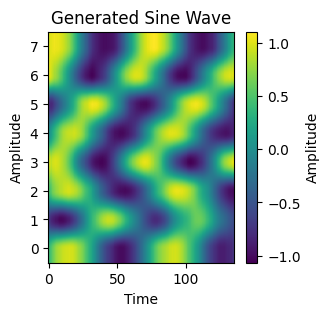

In [72]:
plot_sine_wave(dec_out[0].cpu().detach().numpy().T, title="Generated Sine Wave", xlabel="Time", ylabel="Amplitude")

In [ ]:
# it sounds like produced an interesting wave pattern in the end with relatively small dataset.

# save transformer model
torch.save(wave_generator.state_dict(), "wave_generator.pth")